# An Econophysics model of wealth distribution

The model consists of:

1. Some number of agents, who

2. can have 0 or more units of Money, and 

3. if they have more than 0 units of money, (may) give 1 unit away at random.

4. Additionally, they may be situated on a grid, where multiple agents can be on each cell, and where they give away money only to agents who share a cell with them.

Then we measure the wealth distribution over time.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Mesa imports
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
from mesa.space import MultiGrid

## Simple Model

In [12]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id):
        # Each agent should have a unique_id
        self.unique_id = unique_id 
        self.wealth = 1
    
    def step(self, m):
        """Give money to another agent."""
        if self.wealth > 0:
            # Pick a random agent
            other = random.choice(m.schedule.agents)
            # Give them 1 unit money
            other.wealth += 1
            self.wealth -= 1        

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.create_agents()
        agent_reporters = {"Wealth": lambda a: a.wealth}
        self.dc = DataCollector(agent_reporters=agent_reporters)

    def create_agents(self):
        """Method to create all the agents."""
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)

    def step(self):
        self.schedule.step()
        self.dc.collect(self)

In [39]:
model = MoneyModel(100)

In [40]:
for i in range(1000):
    model.step()

In [41]:
wealths = model.dc.get_agent_vars_dataframe()

In [42]:
wealths.head()

Wealth
Step AgentID        
0    0             0
     1             2
     2             0
     3             1
     4             1

In [43]:
wealths.reset_index(inplace=True)

In [48]:
wealths[wealths.Step==999].Wealth.max()

8

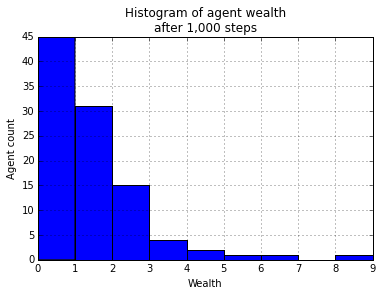

In [50]:
wealths[wealths.Step==999].\
    Wealth.hist(bins=range(10))
    
plt.xlabel("Wealth")
plt.ylabel("Agent count")
plt.title("Histogram of agent wealth\nafter 1,000 steps")

### With changeable initial wealth

In [24]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, wealth):
        # Each agent should have a unique_id
        self.unique_id = unique_id 
        self.wealth = wealth
    
    def step(self, m):
        """Give money to another agent."""
        if self.wealth > 0:
            # Pick a random agent
            other = random.choice(m.schedule.agents)
            # Give them 1 unit money
            other.wealth += 1
            self.wealth -= 1        

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, starting_wealth):
        self.running = True
        self.num_agents = N
        self.starting_wealth=starting_wealth
        self.schedule = RandomActivation(self)
        self.create_agents()
        #agent_reporters = {"Wealth": lambda a: a.wealth}
        #self.dc = DataCollector(agent_reporters=agent_reporters)

    def create_agents(self):
        """Method to create all the agents."""
        for i in range(self.num_agents):
            a = MoneyAgent(i, self.starting_wealth)
            self.schedule.add(a)

    def step(self):
        self.schedule.step()
        #self.dc.collect(self)

In [15]:
model = MoneyModel(100, 5)
for _ in range(1000):
    model.step()

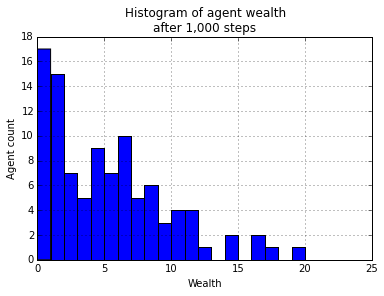

In [79]:
wealths = model.dc.get_agent_vars_dataframe()
wealths.reset_index(inplace=True)
max_wealth = wealths[wealths.Step==999].Wealth.max()
wealths[wealths.Step==999].\
    Wealth.hist(bins=range(max_wealth))
    
plt.xlabel("Wealth")
plt.ylabel("Agent count")
plt.title("Histogram of agent wealth\nafter 1,000 steps")

In [3]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

In [16]:
compute_gini(model)

0.54788

In [41]:
param_values = {"N": 100, "starting_wealth": range(1,10)}
model_reporter={"Gini": compute_gini}
batch = BatchRunner(MoneyModel, param_values, 10, 1000, model_reporter)

In [42]:
batch.run_all()

In [43]:
df = batch.get_model_vars_dataframe()

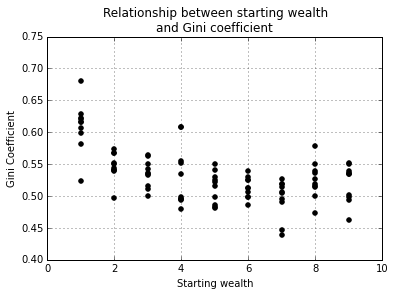

In [44]:
plt.scatter(df.starting_wealth, df.Gini, c='k')
plt.grid(True)
plt.xlabel("Starting wealth")
plt.ylabel("Gini Coefficient")
plt.title("Relationship between starting wealth\nand Gini coefficient")

## With Grid

In [2]:
class Person(Agent):
    wealth = 0
    
    def __init__(self, unique_id, pos, wealth=1):
        '''
        Create a new Agent
        '''
        self.unique_id = unique_id
        self.pos = pos
        self.wealth = wealth
    
    def move(self, model):
        '''
        Take a random step
        '''
        neighbors = model.grid.get_neighborhood(self.pos[0], self.pos[1], 
                                                moore=True, include_center=True)
        choice = random.choice(neighbors) # Pick a random neighboring cell
        if choice != self.pos:
            model.grid.move_agent(self, choice) # Move agent to new position
    
    def exchange_money(self, model):
        '''
        Pick a random neighbor, and give them some money
        '''
        other_agents = model.grid.get_cell_list_contents([self.pos])
        other_agent = self
        if len(other_agents) > 1: # If there is anyone else here
            while other_agent == self:
                other_agent = random.choice(other_agents)
            other_agent.wealth += 1
            self.wealth -= 1
    
    def step(self, model):
        self.move(model)
        if self.wealth > 0:
            self.exchange_money(model)

In [3]:
class MoneyModel(Model):
    
    # Model parameters
    N = 100
    width = 100
    height = 100
    torus = True
    
    def __init__(self, N, width, height, torus):
        self.N = N
        self.width = width
        self.height = height
        self.torus = torus
        
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(self.height, self.width, self.torus)
        
        self.create_agents()
    
    def create_agents(self):
        for i in range(self.N):
            x = random.randrange(self.width)
            y = random.randrange(self.height)
            a = Person(i, (x,y))
            self.schedule.add(a)
            self.grid.place_agent(a, (x,y))
    
    def step(self):
        self.schedule.step()

In [4]:
model = MoneyModel(1000, 100, 100, True)

In [5]:
for _ in range(1000):
    model.step()

(array([ 496.,  243.,  142.,   54.,   41.,   11.,    7.,    3.,    1.,
           1.,    0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 11 Patch objects>)

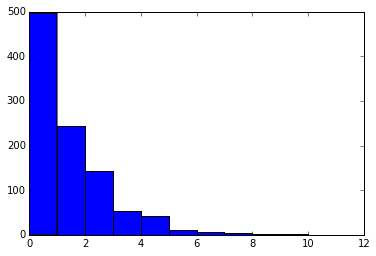

In [6]:
wealths = [agent.wealth for agent in model.schedule.agents]
max_wealth = max(wealths)
plt.hist(wealths, bins=range(max_wealth))

### Static visualizing wealth distribution

In [7]:
wealth_grid = np.zeros((100, 100))

In [10]:
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    cell_wealth = sum(a.wealth for a in cell_content)
    wealth_grid[y,x] = cell_wealth

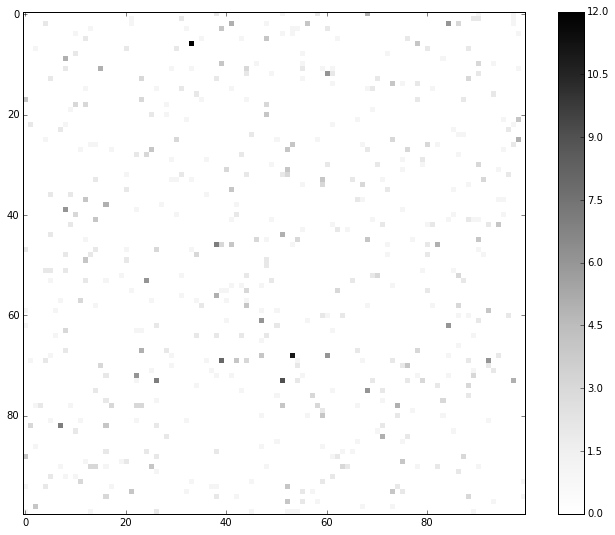

In [18]:
plt.figure(figsize=(12,9))
plt.imshow(wealth_grid, interpolation='nearest',
          cmap=plt.get_cmap('Greys'))
plt.colorbar()

# Gridless Model

In [27]:
class Person(Agent):
    wealth = 0
    
    def __init__(self, unique_id, wealth=1):
        '''
        Create a new Agent
        '''
        self.unique_id = unique_id
        self.wealth = wealth
    
    def exchange_money(self, model):
        '''
        Pick a random neighbor, and give them some money
        '''
        other_agents = model.schedule.agents
        other_agent = self
        if len(other_agents) > 1: # If there is anyone else here
            while other_agent == self:
                other_agent = random.choice(other_agents)
            other_agent.wealth += 1
            self.wealth -= 1
    
    def step(self, model):
        if self.wealth > 0:
            self.exchange_money(model)

In [29]:
class MoneyModel(Model):
    
    # Model parameters
    N = 100
    def __init__(self, N):
        self.N = N
        self.schedule = RandomActivation(self)        
        self.create_agents()
    
    def create_agents(self):
        for i in range(self.N):
            a = Person(i)
            self.schedule.add(a)
    
    def step(self):
        self.schedule.step()

In [33]:
model = MoneyModel(10000)

In [36]:
for _ in range(5000):
    model.step()

(array([  4.58300000e+03,   2.94700000e+03,   1.36300000e+03,
          5.82000000e+02,   2.83000000e+02,   1.23000000e+02,
          6.40000000e+01,   3.00000000e+01,   1.10000000e+01,
          4.00000000e+00,   3.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   2.00000000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 14 Patch objects>)

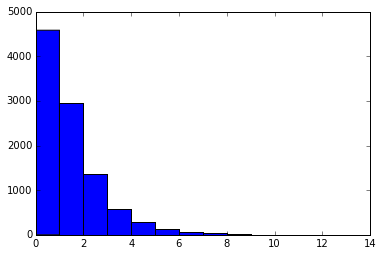

In [37]:
wealths = [agent.wealth for agent in model.schedule.agents]
max_wealth = max(wealths)
plt.hist(wealths, bins=range(max_wealth))